# First steps through pyiron

This section gives a brief introduction about fundamental concepts of pyiron and how they can be used to setup, run and analyze atomic simulations. As a first step we import the libraries [numpy](http://www.numpy.org/) for data analysis and [matplotlib](https://matplotlib.org/) for visualization.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

To import pyiron simply use:

In [2]:
from pyiron_atomistic import Project

The Project object introduced below is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus, by code completion *Tab* the respective commands can be found easily.

We now create a pyiron Project named 'first_steps'.

In [3]:
pr = Project(path='first_steps')

The project name also applies for the directory that is created for the project.

## Perform a LAMMPS MD simulation

Having created an instance of the pyiron Project we now perform a [LAMMPS](http://lammps.sandia.gov/) molecular dynamics simulation.

For this basic simulation example we construct an fcc Al crystal in a cubic supercell (`cubic=True`). For more details on generating structures, please have a look at our [structures example](./structures.ipynb)

In [4]:
basis = pr.create_ase_bulk('Al', cubic=True)
supercell_3x3x3 = basis.repeat([3, 3, 3])
supercell_3x3x3.plot3d()

NGLWidget()

Here `create_ase_bulk` uses the [ASE bulk module](https://wiki.fysik.dtu.dk/ase/ase/build/build.html). The structure can be modified - here we extend the original cell to a 3x3x3 supercell (`repeat([3, 3, 3]`). Finally, we plot the structure using [NGlview](http://nglviewer.org/nglview/latest/api.html).

The project object allows to create various simulation job types. Here, we create a LAMMPS job.

In [5]:
job = pr.create_job(job_type=pr.job_type.Lammps, job_name='Al_T800K')

Further, we specify a Molecular Dynamics simulation at $T=800$ K using the supercell structure created above.

In [6]:
job.structure = supercell_3x3x3
job.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)

To see all available interatomic potentials which are compatible with the structure (for our example they must contain Al) and the job type (here LAMMPS) we call `job.list_potentials()`.

In [7]:
job.list_potentials()

['Al_Mg_Mendelev_eam', 'Zope_Ti_Al_2003_eam', 'Al_H_Ni_Angelo_eam']

From the above let us select the first potential in the list.

In [8]:
pot = job.list_potentials()[0]
print ('Selected potential: ', pot)
job.potential = pot

Selected potential:  Al_Mg_Mendelev_eam


To run the LAMMPS simulation (locally) we now simply use:

In [9]:
job.run()

## Analyze the calculation

After the simulation has finished the information about the job can be accessed through the Project object.

In [10]:
job = pr['Al_T800K']
job

{'groups': ['input', 'output'], 'nodes': ['NAME', 'server', 'VERSION', 'TYPE']}

Printing the job object (note that in Jupyter we don't have to call a print statement if the variable/object is in the last line). The output lists the variables (nodes) and the directories (groups). To get a list of all variables stored in the generic output we type:

In [11]:
job['output/generic']

{'groups': [], 'nodes': ['temperatures', 'positions', 'steps', 'forces', 'energy_pot', 'energy_tot', 'volume', 'cells', 'pressures', 'unwrapped_positions', 'time']}

An animated 3d plot of the MD trajectories is created by:

In [12]:
job.animate_structure()

NGLWidget(count=101)

To analyze the temperature evolution we plot it as function of the MD step.

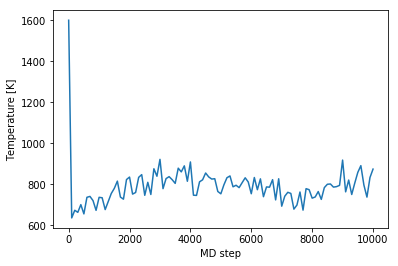

In [13]:
temperatures = job['output/generic/temperature']
steps = job['output/generic/steps']
plt.plot(steps, temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]');

In the same way we can plot the trajectories.

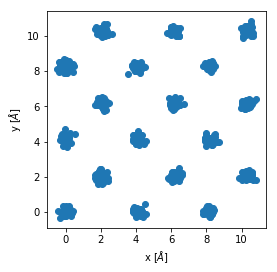

In [14]:
pos = job['output/generic/positions']
x, y, z = [pos[:, :, i] for i in range(3)]
sel = np.abs(z) < 0.1
fig, axs = plt.subplots(1,1)
axs.scatter(x[sel], y[sel])
axs.set_xlabel('x [$\AA$]')
axs.set_ylabel('y [$\AA$]')
axs.set_aspect('equal', 'box');

## Perform a series of jobs

To run the MD simulation for various temperatures we can simply loop over the desired temperature values.

In [15]:
for temperature in np.arange(200, 1200, 200):
    job = pr.create_job(pr.job_type.Lammps, 
                        'Al_T{}K'.format(int(temperature)))
    job.structure = supercell_3x3x3
    job.potential = pot     
    job.calc_md(temperature=temperature, 
                pressure=0, 
                n_ionic_steps=10000)
    job.run()

To inspect the list of jobs in our current project we type (note that the existing job from the previous excercise at $T=800$ K has been recognized and not run again):

In [16]:
pr

['Al_T600K', 'Al_T800K', 'Al_T1000K', 'Al_T200K', 'Al_T400K']

We can now iterate over the jobs and extract volume and mean temperature.

In [17]:
vol_lst, temp_lst = [], []
for job in pr.iter_jobs(convert_to_object=False):
    volumes = job['output/generic/volume']
    temperatures = job['output/generic/temperature']
    temp_lst.append(np.mean(temperatures[:-20]))
    vol_lst.append(np.mean(volumes[:-20]))

Then we can use the extracted information to plot the thermal expansion, calculated within the $NPT$ ensemble. For plotting the temperature values in ascending order the volume list is mapped to the sorted temperature list.

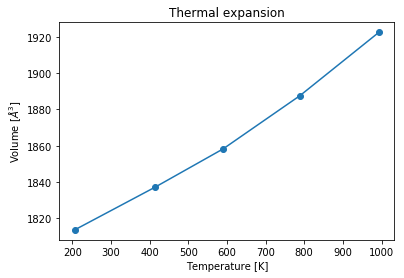

In [18]:
plt.figure()
vol_lst[:] = [vol_lst[np.argsort(temp_lst)[k]] 
              for k in range(len(vol_lst))]
plt.plot(sorted(temp_lst), vol_lst, 
         linestyle='-',marker='o',)
plt.title('Thermal expansion')
plt.xlabel('Temperature [K]')
plt.ylabel('Volume [$\AA^3$]');

## Create a series of projects

We extend the previous example and compute the thermal expansion for three of the available aluminum potentials. First, let us create a new pyiron project named 'Al_potentials'. We can use the information of the previously run job 'Al_T200K' of the 'first_steps' project to find all the compatible potentials.

In [19]:
pr = Project('Al_potentials')
pot_lst = pr['../first_steps/Al_T200K'].load_object().list_potentials()[:3]

In [20]:
pot_lst

['Al_Mg_Mendelev_eam', 'Zope_Ti_Al_2003_eam', 'Al_H_Ni_Angelo_eam']

Note again that `list_potentials()` automatically only returns the potentials that are compatible with the structure (chemical species) and the job type.

We can now loop over the selected potentials and run the MD simulation for the desired temperature values for any of the potentials.

In [21]:
for pot in pot_lst:
    print ('Interatomic potential used: ',pot)
    pr_pot = pr.create_group(pot)
    for temperature in np.arange(200, 1200, 200):
        job = pr_pot.create_job(pr.job_type.Lammps, 
                                'Al_T{}K'.format(int(temperature)))
        job.structure = supercell_3x3x3
        job.potential = pot                
        job.calc_md(temperature=temperature, 
                    pressure=0, 
                    n_ionic_steps=10000)
        job.run()

Interatomic potential used:  Al_Mg_Mendelev_eam
Interatomic potential used:  Zope_Ti_Al_2003_eam
Interatomic potential used:  Al_H_Ni_Angelo_eam


With the `pr.create_group()` command a new subproject (directory) is created named here by the name of the potential. 

For any particular potential the thermal expansion data can be obtained again by looping over the jobs performed using that potential. To obtain the thermal expansion curves for all the potentials used we can simply iterate over the subprojects (directories) created above by using the `pr.iter_groups()` command.

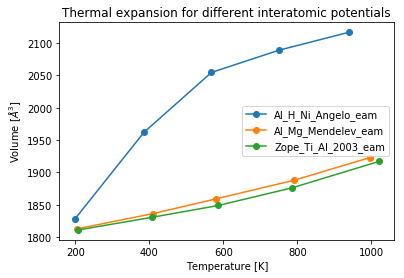

In [22]:
for p in pr.iter_groups():
    vol_lst, temp_lst = [], []
    for out in p.iter_jobs(path='output/generic'):
        volumes = out['volume']
        temperatures = out['temperature']
        temp_lst.append(np.mean(temperatures[:-20]))
        vol_lst.append(np.mean(volumes[:-20]))
    # Plot only if there is a job in that group
    if len(p.get_job_ids()) > 0:
        plt.plot(temp_lst, vol_lst, 
                 linestyle='-',marker='o',
                 label=p.name) 
plt.legend(loc='best')    
plt.title('Thermal expansion for different interatomic potentials')
plt.xlabel('Temperature [K]')
plt.ylabel('Volume [$\AA^3$]');